# Allstate Claims Severity

## Initialization

In [84]:
import time
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

## Data preparation

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample = pd.read_csv('../data/sample_submission.csv')

In [3]:
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [5]:
train.columns

Index(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9',
       ...
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14', 'loss'],
      dtype='object', length=132)

In [6]:
test.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB


In [8]:
test.columns

Index(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9',
       ...
       'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11',
       'cont12', 'cont13', 'cont14'],
      dtype='object', length=131)

In [9]:
train.cat5.value_counts()

A    123737
B     64581
Name: cat5, dtype: int64

In [10]:
sample.head()

,id,loss
0,4,0
1,6,0
2,9,0
3,12,0
4,15,0


In [11]:
outcome = train.loss
train.drop(['id', 'loss'], axis=1, inplace=True)
testId = test['id']
test.drop(['id'], axis=1, inplace=True)
train['Test'] = False
test['Test'] = True
data = pd.concat([train, test], ignore_index=True)

In [12]:
data = pd.get_dummies(data, columns=data.columns[:116])

In [13]:
data.columns

Index(['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8',
       'cont9', 'cont10',
       ...
       'cat116_P', 'cat116_Q', 'cat116_R', 'cat116_S', 'cat116_T', 'cat116_U',
       'cat116_V', 'cat116_W', 'cat116_X', 'cat116_Y'],
      dtype='object', length=1191)

## Machine Learning

In [14]:
train = data[data.Test == 0].drop('Test', axis=1).copy()
test = data[data.Test == 1].drop('Test', axis=1).copy()
del data

In [15]:
X = train
y = outcome
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.15, random_state=777)

In [16]:
Xtr.shape, Xval.shape

((160070, 1190), (28248, 1190))

### XGBoost

In [26]:
# read in data
dtrain = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(test)

In [27]:
dtrain_tr = xgb.DMatrix(Xtr, label=ytr)
dtest_val = xgb.DMatrix(Xval)

#### 1. Default XGBoost - with 2 rounds

In [28]:
param = { 'eval_metric':'mae', 'objective':'reg:linear' }
num_rounds = 2

In [29]:
xgb1 = xgb.train(param, dtrain_tr, num_rounds)

In [30]:
xgb1_pred = xgb1.predict(dtest_val)

In [31]:
xgb1_mae = mean_absolute_error(yval, xgb1_pred, sample_weight=None, multioutput='uniform_average')
xgb1_mae

1679.1210906448298

#### 2. Default XGBoost - with 100 rounds

In [32]:
# specify parameters via map
#param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'reg:linear' }
param = { 'eval_metric':'mae', 'objective':'reg:linear' }
num_rounds = 100

In [33]:
xgb2 = xgb.train(param, dtrain_tr, num_rounds)

In [34]:
# make prediction
xgb2_pred = xgb2.predict(dtest_val)

In [35]:
xgb2_mae = mean_absolute_error(yval, xgb2_pred, sample_weight=None, multioutput='uniform_average')
xgb2_mae

1201.2805777230014

#### 3.1. XGBoost CV - Set learning rate to 0.3 and perfrom cv to find optimal num_rounds

In [36]:
param = {'eta':0.3, 'eval_metric':'mae', 'objective':'reg:linear' }

In [37]:
start_time = time.time()
xgb_cv = xgb.cv(param, dtrain_tr, num_boost_round=1000, nfold=5, early_stopping_rounds=50)
print("--- %s seconds ---" % (time.time() - start_time))

--- 160.24571180343628 seconds ---


In [38]:
xgb_cv

,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
0,2158.680811,12.312323,2157.669531,2.731807
1,1675.954981,9.619065,1673.415234,4.620844
2,1455.545874,11.433872,1450.544360,5.889285
3,1356.556274,11.559346,1348.434888,4.843428
4,1315.894312,12.392191,1304.443555,4.589680
5,1294.572729,10.651805,1279.833813,2.885116
6,1283.791040,9.454872,1266.412940,2.200539
7,1279.882129,10.392954,1259.739063,0.978944
8,1274.369922,9.392333,1252.147949,1.535901
9,1268.736157,9.737504,1244.062622,1.165354


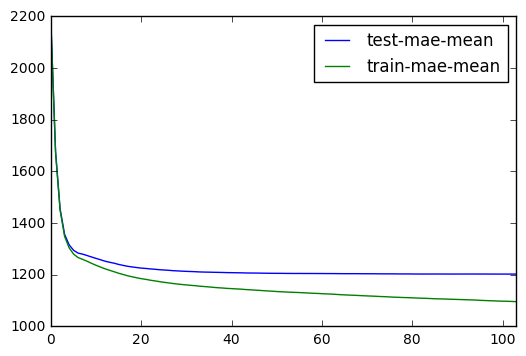

In [39]:
xgb_cv.plot(y=['test-mae-mean', 'train-mae-mean'])

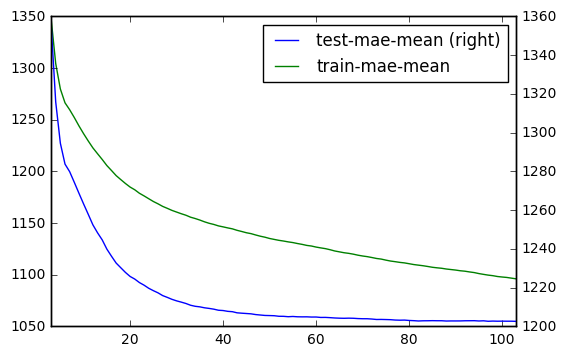

In [40]:
xgb_cv[3:].plot(y=['test-mae-mean', 'train-mae-mean'], secondary_y='test-mae-mean')

In [41]:
xgb_cv['test-mae-mean'].argmin()

103

In [42]:
xgb_cv.loc[103]

test-mae-mean     1202.627588
test-mae-std         7.562366
train-mae-mean    1096.087695
train-mae-std        3.024768
Name: 103, dtype: float64

In [43]:
num_rounds = xgb_cv['test-mae-mean'].argmin()

#### 3.2. XGBoost CV - refit model with estimated num_rounds

In [44]:
start_time = time.time()
xgb3 = xgb.train(param, dtrain_tr, num_rounds)
print("--- %s seconds ---" % (time.time() - start_time))

--- 21.6729896068573 seconds ---


In [45]:
xgb3_pred = xgb3.predict(dtest_val)

In [46]:
xgb3_mae = mean_absolute_error(yval, xgb3_pred, sample_weight=None, multioutput='uniform_average')
xgb3_mae

1201.4168691291152

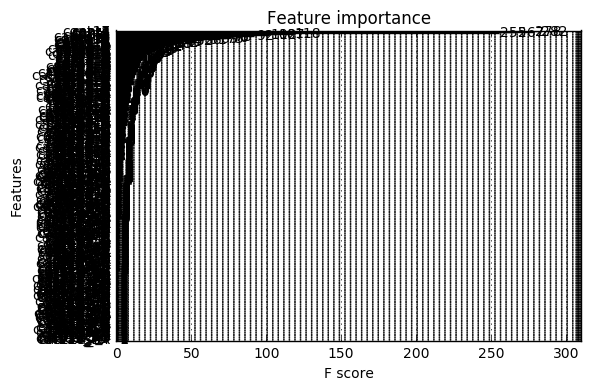

In [47]:
xgb.plot_importance(xgb3)

In [48]:
imps = pd.Series(xgb3.get_fscore()).sort_values()

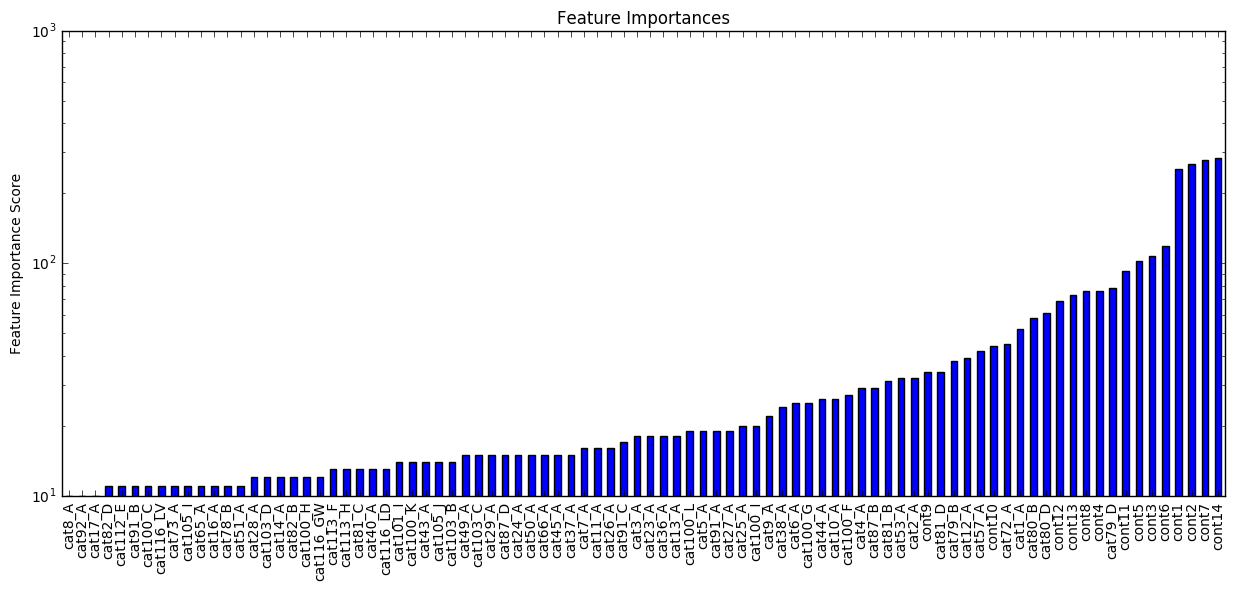

In [49]:
imps[400:].plot(kind='bar', figsize=(15,6),logy=True, title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### 4.1. XGBoost CV - Lower learning rate to 0.1 and perfrom cv to find optimal num_rounds

In [50]:
param = {'eta':0.1, 'eval_metric':'mae', 'objective':'reg:linear' }

In [51]:
start_time = time.time()
xgb_cv2 = xgb.cv(param, dtrain_tr, num_boost_round=1000, nfold=5, early_stopping_rounds=50)
print("--- %s seconds ---" % (time.time() - start_time))

--- 444.0704128742218 seconds ---


In [52]:
xgb_cv2

,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
0,2734.748340,13.390094,2734.667236,3.260176
1,2467.183447,12.685852,2466.739648,2.979399
2,2235.907813,12.343284,2235.286670,2.896660
3,2042.556421,12.403301,2041.406641,2.549383
4,1883.062158,11.962605,1881.398633,2.597335
5,1753.693189,11.625796,1751.311743,2.656002
6,1650.430981,11.829814,1647.446314,1.876082
7,1568.016065,12.540847,1564.213159,1.758753
8,1503.380151,12.557919,1498.715112,2.142991
9,1453.076392,12.326726,1447.535620,2.078956


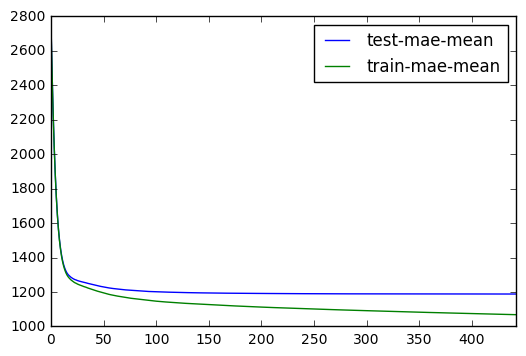

In [53]:
xgb_cv2.plot(y=['test-mae-mean', 'train-mae-mean'])

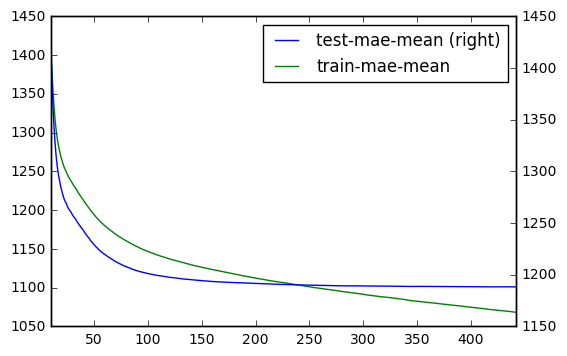

In [54]:
xgb_cv2[10:].plot(y=['test-mae-mean', 'train-mae-mean'], secondary_y='test-mae-mean')

In [55]:
xgb_cv2['test-mae-mean'].argmin()

442

In [56]:
xgb_cv2.loc[442]

test-mae-mean     1188.273755
test-mae-std         7.657707
train-mae-mean    1068.306031
train-mae-std        2.125791
Name: 442, dtype: float64

In [57]:
num_rounds = xgb_cv2['test-mae-mean'].argmin()

#### 4.2. XGBoost CV - refit model with estimated num_rounds

In [58]:
start_time = time.time()
xgb4 = xgb.train(param, dtrain_tr, num_rounds)
print("--- %s seconds ---" % (time.time() - start_time))

--- 89.37668776512146 seconds ---


In [59]:
xgb4_pred = xgb4.predict(dtest_val)

In [60]:
xgb4_mae = mean_absolute_error(yval, xgb4_pred, sample_weight=None, multioutput='uniform_average')
xgb4_mae

1186.5947129950503

In [61]:
imps = pd.Series(xgb4.get_fscore()).sort_values()

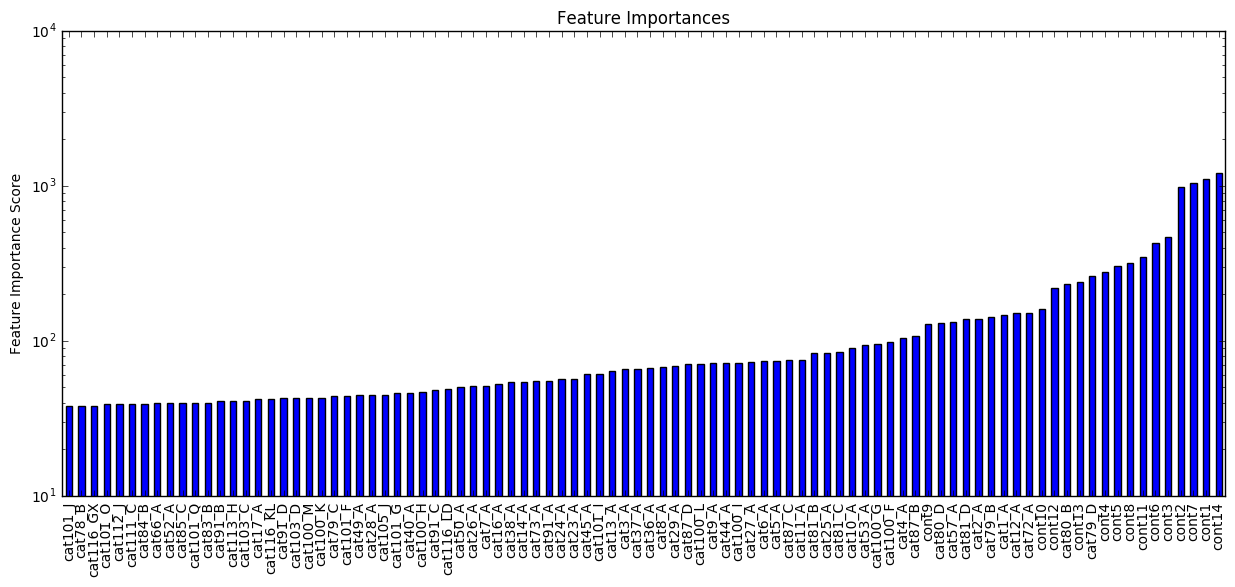

In [62]:
imps[500:].plot(kind='bar', figsize=(15,6),logy=True, title='Feature Importances')
plt.ylabel('Feature Importance Score')

**General Parameters**
* booster [default=gbtree]
* silent [default=0]
* nthread [default to maximum number of threads available if not set]
* num_pbuffer [set automatically by xgboost, no need to be set by user]
* num_feature [set automatically by xgboost, no need to be set by user]

**Parameters for Tree Booster**
* **eta = 0.1** [default=0.3], range: [0,1]
* gamma [default=0], range: [0,∞]
* max_depth [default=6], range: [1,∞]
* min_child_weight [default=1], range: [0,∞]
* max_delta_step [default=0], range: [0,∞]
* subsample [default=1], range: (0,1]
* colsample_bytree [default=1], range: (0,1]
* colsample_bylevel [default=1], range: (0,1]
* lambda [default=1]
* alpha [default=0]
* tree_method, string [default=’auto’], Choices: {‘auto’, ‘exact’, ‘approx’}
* sketch_eps, [default=0.03], range: (0, 1)
* scale_pos_weight, [default=1]
* updater_seq, [default=”grow_colmaker,prune”]

**Learning Task Parameters**
* **objective = 'reg:linear'** [ default=reg:linear ]
* base_score [ default=0.5 ]
* **eval_metric = 'mae'** [ default according to objective ]
* seed [ default=0 ]


#### 5. Replicate previous XGBoost results using sklrearn API

In [63]:
xgb5 = xgb.XGBRegressor(learning_rate=0.1, n_estimators=num_rounds, max_depth=6)

In [64]:
start_time = time.time()
xgb5.fit(Xtr, ytr, eval_metric='mae')
print("--- %s seconds ---" % (time.time() - start_time))

--- 96.09558129310608 seconds ---


In [65]:
xgb5_pred = xgb5.predict(Xval)
xgb5_mae = mean_absolute_error(yval, xgb5_pred, sample_weight=None, multioutput='uniform_average')
xgb5_mae

1186.5947129950503

#### 6. Tune max_depth and min_child_weight

In [66]:
param_gridsearch = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}

In [67]:
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=num_rounds, max_depth=6),
                        param_grid = param_gridsearch, scoring='mean_absolute_error',n_jobs=-1, iid=False, cv=5)

In [68]:
gsearch1

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=442, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [69]:
start_time = time.time()
gsearch1.fit(X, y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 8277.61771607399 seconds ---


In [73]:
gsearch1.best_params_

{'max_depth': 7, 'min_child_weight': 3}

In [71]:
gsearch1.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=442, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [74]:
gsearch1.best_score_

-1184.5639581024693

In [78]:
gsearch1.grid_scores_

[mean: -1208.87851, std: 6.28339, params: {'min_child_weight': 1, 'max_depth': 3},
 mean: -1207.41744, std: 6.03382, params: {'min_child_weight': 3, 'max_depth': 3},
 mean: -1207.33724, std: 6.73638, params: {'min_child_weight': 5, 'max_depth': 3},
 mean: -1188.63742, std: 6.31087, params: {'min_child_weight': 1, 'max_depth': 5},
 mean: -1188.87583, std: 7.08116, params: {'min_child_weight': 3, 'max_depth': 5},
 mean: -1188.88994, std: 6.29933, params: {'min_child_weight': 5, 'max_depth': 5},
 mean: -1185.72311, std: 6.38585, params: {'min_child_weight': 1, 'max_depth': 7},
 mean: -1184.56396, std: 6.62433, params: {'min_child_weight': 3, 'max_depth': 7},
 mean: -1184.83147, std: 6.85457, params: {'min_child_weight': 5, 'max_depth': 7},
 mean: -1187.61806, std: 5.15353, params: {'min_child_weight': 1, 'max_depth': 9},
 mean: -1187.16711, std: 6.43681, params: {'min_child_weight': 3, 'max_depth': 9},
 mean: -1187.43262, std: 6.22267, params: {'min_child_weight': 5, 'max_depth': 9}]

In [86]:
joblib.dump(gsearch1.best_estimator_, '../models/xgboost_gsearch1.pkl')

['../models/xgboost_gsearch1.pkl']

#### 7. Tune max_depth and min_child_weight deeper

In [ ]:
param_gridsearch2 = {
 'max_depth':[6,7,8],
 'min_child_weight':[2,3,4]
}

In [ ]:
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=num_rounds, max_depth=6),
                        param_grid = param_gridsearch, scoring='mean_absolute_error',n_jobs=-1, iid=False, cv=5)

In [ ]:
gsearch1

In [ ]:
start_time = time.time()
gsearch1.fit(X, y)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
gsearch1.best_params_

In [ ]:
gsearch1.best_estimator_

In [ ]:
gsearch1.best_score_

In [ ]:
gsearch1.grid_scores_

In [ ]:
joblib.dump(gsearch1.best_estimator_, '../models/xgboost_gsearch1.pkl')

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [80]:
xgb_gsearch1_pred = gsearch1.best_estimator_.predict(test)

In [81]:
xgb_submit = pd.DataFrame({'id': testId, 'loss': xgb_gsearch1_pred})

In [82]:
xgb_submit.to_csv('../output/2016-11-28-bff-xgboost-gridsearch.csv', index=False)

Train model using full train set and make prediction on test set

In [117]:
xgb_bst = xgb.train(param, dtrain, num_rounds)

In [118]:
xgb_bst_pred = xgb_bst.predict(dtest)

In [119]:
xgb_submit = pd.DataFrame({'id': testId, 'loss': xgb_bst_pred})

In [120]:
xgb_submit.head()

,id,loss
0,4,1623.605835
1,6,1917.157349
2,9,10121.073242
3,12,6659.223145
4,15,907.076294


In [121]:
xgb_submit.to_csv('../output/2016-11-21-bff-xgboost-cv2.csv', index=False)